In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import glob
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
import spimagine
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from matplotlib import cm
%matplotlib inline

no scikit-tensor detected, so separable functions wont work
This is a python3 issue and can be resolved by:

git clone https://github.com/mnick/scikit-tensor.git
pip3 install scikit-tensor
[Errno 2] No such file or directory: '/Users/dsaha/.spimagine'


In [2]:
# param : img:   3D numpy array, image
#         neighborhood_size : tuple of ints, kernel size for maxima and minma filter (z,y,x)
#         threshold : int, determines the threshold differnece between maximum peak intensity and background to count as a bead

def detectBeads(img,neighborhood_size = (50,15,15),threshold = 1500):
    
    data = img
    
    # Bead segmentation, the mask of the bead is in maxima
    print("Bead Mask formation")
    data_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_max)                                    
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    # Isolating beads from the mask
    print("Bead Mask labeling")
    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    x, y, z = [], [], []
    for dz,dy,dx in slices:
        z_center = (dz.start + dz.stop - 1)/2
        z.append(z_center)
        x_center = (dx.start + dx.stop - 1)/2
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2    
        y.append(y_center)
    
    return (z,y,x,num_objects)

In [203]:
# param : img:   3D numpy array, image
#         pos:   2D numpy array, positions of all beads in n*[z,y,x] format
#         title: String, title for the plot 

def visualizeBeadDetectionByMaxProjection(img,pos, title = "Image"):
    z,y,x = pos[:,0],pos[:,1],pos[:,2]
    plt.figure(figsize=(10,10))
    plt.imshow(np.log(np.max(img,axis = 0)))
    plt.axis('OFF')
    plt.title(title)
    for i,_ in enumerate(x):
        plt.plot(x[i],y[i],'r.',alpha = 0.15)
    plt.show()

In [4]:
# param: fileName: String, entire path with the filename 
#        rawImage: Boolean, if tiff file to be loaded or raw microscope image
#        dimZ,dimY,dimX: int, the dimensions, required only for raw image

def loadImage(fileName, rawImage = True, dimZ = 100, dimY = 512, dimX = 512):
    if rawImage:
        return (np.fromfile(fileName,dtype=np.dtype('<u2')).reshape((dimZ,dimY,dimX)))
    else:
        return tifffile.imread(fileName)

In [5]:
# param: img:   3D numpy array, image
#        limit: a tuple of 3 ints, extent to extract in the 3 dimension 
# .      n:     int, number of beads
#        pos:   2D numpy array, positions of all beads in n*[z,y,x] format

def extract1DSignalForAllBeadsInAll3Dims(img,limit,n,pos):
    z,y,x = pos[:,0],pos[:,1],pos[:,2]
    zrange,yrange,xrange = limit[0],limit[1],limit[2]
    switcher = {
        'z': [img[np.maximum(int(z[i])-(zrange//2),0):np.minimum(int(z[i])+(zrange//2),img.shape[0]),int(y[i]),int(x[i])] for i in range(n)],
        'y': [img[int(z[i]),np.maximum(int(y[i])-(yrange//2),0):np.minimum(int(y[i])+(yrange//2),img.shape[1]),int(x[i])] for i in range(n)],
        'x': [img[int(z[i]),int(y[i]),np.maximum(int(x[i])-(xrange//2),0):np.minimum(int(x[i])+(xrange//2),img.shape[2])] for i in range(n)],
    } 
    ZSignal = switcher.get('z', "Invalid Dimension")
    YSignal = switcher.get('y', "Invalid Dimension")
    XSignal = switcher.get('x', "Invalid Dimension")
    return (ZSignal,YSignal,XSignal)

In [6]:
# param: x : int, independent variable
#       amp: int/float, amplitude of the gaussian
#       cen: int/float, center of the gaussian
#       wid: int/float, width of the gaussian
#       ydisp: int.float, background
def gaussian(x, amp, cen, wid, ydisp):
     return (amp * np.exp(-(x-cen)**2 / wid) + ydisp)
    

# param: img:   3D numpy array, image
# .      n:     int, number of beads
#        pos:   2D numpy array, positions of all beads in n*[z,y,x] format 
#        signal: list of numpy array, each member of the list is a bead. numpy ar
#        insBead: 1D boolean array, if the detected bead is indeed a bead
def fitForAllBeads(img, n, pos, signal,isBead):
    numParams = 4
    fitParam = np.zeros((n,numParams))
    err = np.zeros((n,numParams))
    
    z,y,x = pos[:,0],pos[:,1],pos[:,2]

    for beadNum in range(n):
        #print(beadNum)
        initialVals = [img[int(z[beadNum]),int(y[beadNum]),int(x[beadNum])], len(signal[beadNum])//2, len(signal[beadNum])//2, np.min(signal[beadNum])]  #[amp, cen, wid, ydisplacement]
        try:
            # curve_fit(model,x,y,initialValues)
            bestVals, covar = curve_fit(gaussian, range(len(signal[beadNum])), signal[beadNum], p0=initialVals)
            fitParam[beadNum] = bestVals
        except:
            isBead[beadNum] = 0
            continue
        err[beadNum] = np.sqrt(np.diag(covar))
    return (fitParam,err,isBead)

In [256]:
# param : isBead: 1D boolean array, if the detected bead is indeed a bead
#         param: 2D numpy array, (n*m) where n is number of beads and m is number of paramenters for fitting
#         err: 2D numpy array, (n*m) where n is number of beads and m is error number in each parameter fitting
#         widthThreshold: int, threshold for maximum width of the gaussian that is fitted

def checkTheFitOfBead(isBead, param, err, limit):
    for beadNum in range(err.shape[0]):
        if np.any(np.isinf(err[beadNum])): # Very high variance in any parameter of fitting cannot be a bead
            isBead[beadNum] = 0
            continue
        if param[beadNum, 0] <= 0: # Inverted Gaussian cannot be a bead
            isBead[beadNum] = 0
            continue
        if err[beadNum,2] > limit: # Large variance in the width of the bead, typically greater than the window size 
            isBead[beadNum] = 0
            continue      
    return isBead

In [257]:
def visualizeDeletedBeads(img, isBead, xLimit, yLimit, pos):
    z,y,x = pos[:,0],pos[:,1],pos[:,2]
    for beadNum in range(len(isBead)):
        if isBead[beadNum]== 0:
            plt.figure(figsize = (2,2))
            plt.imshow(img[int(z[beadNum]),
                   np.maximum(int(y[beadNum])-(yLimit//2),0):np.minimum(int(y[beadNum])+(yLimit//2),img.shape[1]),
                    np.maximum(int(x[beadNum])-(xLimit//2),0):np.minimum(int(x[beadNum])+(xLimit//2),img.shape[2])])
            plt.yticks([])
            plt.axhline(y[beadNum]-np.maximum(int(y[beadNum])-(yLimit//2),0), color='r', linestyle='--',linewidth = 1)
            plt.axvline(x[beadNum]-np.maximum(int(x[beadNum])-(xLimit//2),0), color='r', linestyle='--',linewidth = 1)
            plt.title("Deleted Bead Nr %d"%beadNum)
            plt.show()

In [258]:
# param : isBead: 1D boolean array, if the detected bead is indeed a bead
#         param: 2D numpy array, (n*m) where n is number of beads and m is number of paramenters for fitting
#         err: 2D numpy array, (n*m) where n is number of beads and m is error number in each parameter fitting
#         n: int, number of beads
#         pos: 2D numpy array, (n*m) n = number of beads, m= 3 for x,y,z

def deleteBeads(isBead, param, err, n, pos):
    param1 = []
    err1 = []
    pos1 = []
    for beadNum in range(n):
        #print(beadNum)
        if isBead[beadNum]:
            param1.append(param[beadNum])
            err1.append(err[beadNum])
            pos1.append(pos[beadNum])
    return (np.array(param1),np.array(err1),np.array(pos1))



Detecting all objects that can qualify as beads
Bead Mask formation
Bead Mask labeling
Detected 210 objects that can qualify as beads


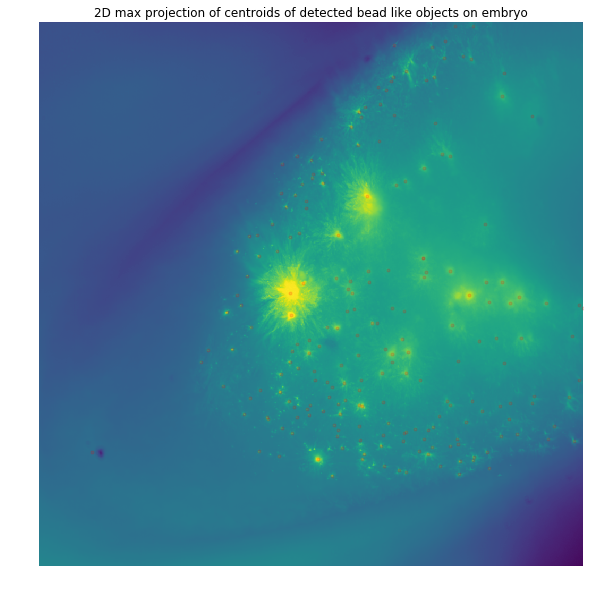

Extracting 1D signals along x, y and z axis
Gaussian fitting of signal from propbable beads in all 3 dimensions


/Users/dsaha/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt
/Users/dsaha/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/dsaha/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys


Checking which of the detected objects qaulify as beads
Deleting information about objects not qualified as beads


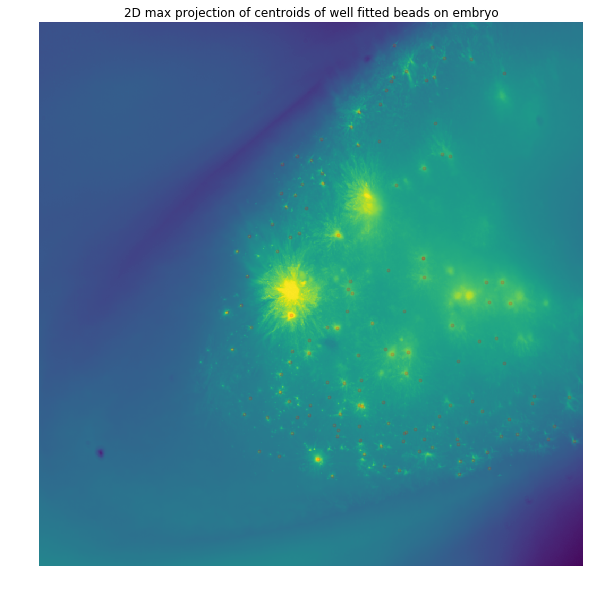

In [291]:
# Scaled down droso image
#img = loadImage("/Users/dsaha/Desktop/000000-2.tif",False)
#gImg = filters.gaussian_filter(img,2)

print("Detecting all objects that can qualify as beads")
(z,y,x,n) = detectBeads(gImg,threshold=2000,neighborhood_size=(50,30,30))
isBead = np.ones((n)) # will contain information about the detected beads that actually qualify as beads
detectedBeadPos = np.array([(z[i],y[i],x[i]) for i in range(n) if isBead[i]])
print("Detected %d objects that can qualify as beads"%n)

visualizeBeadDetectionByMaxProjection(img,detectedBeadPos,"2D max projection of centroids of detected bead like objects on embryo")


print("Extracting 1D signals along x, y and z axis")
zLimit,yLimit,xLimit = 100,64,64 #The range for extracting 1D signal along respective axis
ZSignal,YSignal,XSignal = extract1DSignalForAllBeadsInAll3Dims(img,(zLimit,yLimit,xLimit),n,detectedBeadPos)

print("Gaussian fitting of signal from propbable beads in all 3 dimensions")
ZParam,ZErr,isBead = fitForAllBeads(img,n,detectedBeadPos,ZSignal,isBead)
YParam,YErr,isBead = fitForAllBeads(img,n,detectedBeadPos,YSignal,isBead)
XParam,XErr,isBead = fitForAllBeads(img,n,detectedBeadPos,XSignal,isBead)

print("Checking which of the detected objects qaulify as beads")
isBead = checkTheFitOfBead(isBead, ZParam, ZErr, zLimit)
isBead = checkTheFitOfBead(isBead, YParam, YErr, yLimit/4)
isBead = checkTheFitOfBead(isBead, XParam, XErr, xLimit/4)

# Visulaize Deleted Beads
#visualizeDeletedBeads(img,isBead,xLimit,yLimit,detectedBeadPos)

# Visulaize the well fitted Beads
#visualizeWellFittedBeads(isBead, XParam, YParam, XSignal, YSignal, xLimit, yLimit, pos)

print("Deleting information about objects not qualified as beads")
(ZParam,ZErr,z) = deleteBeads(isBead, ZParam, ZErr, n, z)
(YParam,YErr,y) = deleteBeads(isBead, YParam, YErr, n, y)
(XParam,XErr,x) = deleteBeads(isBead, XParam, XErr, n, x)



assert(len(z) == len (y) == len(x) == len(ZParam) == len(YParam) == len(XParam) == len(ZErr) == len(YErr) == len(XErr))

n = len(z)
isBead = np.ones(n)
beadPos = np.array([(z[i],y[i],x[i]) for i in range(n) if isBead[i]]) #This is where lies the final beads positions


visualizeBeadDetectionByMaxProjection(img,beadPos, "2D max projection of centroids of well fitted beads on embryo")

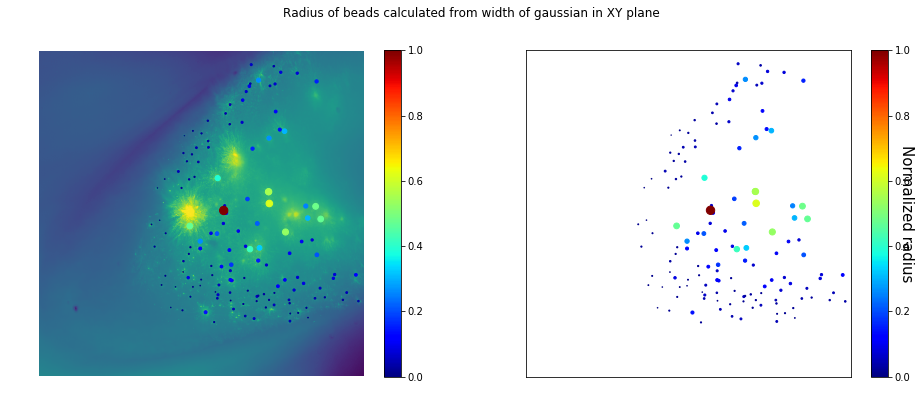

In [292]:
def visualizeSizesOfBeads(img,radius,x,y, title = "Image"):
    mul = 70 
    plt.figure(figsize=(16,6))
    plt.suptitle(title)
    plt.subplot(1,2,1)
    plt.imshow(np.log(np.max(img,axis = 0)))
    plt.axis('OFF')
    cm = plt.cm.get_cmap('jet')
    sc=plt.scatter(x,y,c=radius, s=radius*mul,cmap = cm)
    plt.colorbar(sc)
    plt.subplot(1,2,2)
    plt.ylim(0,img.shape[1])
    plt.xlim(0,img.shape[2])
    sc=plt.scatter(x,y,c=radius, s=radius*mul,cmap = cm)
    cbar = plt.colorbar()
    cbar.set_label('Normalized radius', rotation=270, size = 15)
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.show

#zWidth = (np.array(ZParam)[:,2] - np.min(np.array(ZParam)[:,2]))/(np.max(np.array(ZParam)[:,2]) - np.min(np.array(ZParam)[:,2]))
yWidth = (np.array(YParam)[:,2] - np.min(np.array(YParam)[:,2]))/(np.max(np.array(YParam)[:,2]) - np.min(np.array(YParam)[:,2]))
xWidth = (np.array(XParam)[:,2] - np.min(np.array(XParam)[:,2]))/(np.max(np.array(XParam)[:,2]) - np.min(np.array(XParam)[:,2]))
xyRadius = np.sqrt(np.square(xWidth) + np.square(yWidth))
xyRadius = (xyRadius - np.min(xyRadius))/(np.max(xyRadius) - np.min(xyRadius))
#visualizeSizesOfBeads(img,zWidth,x,y,"Width of gaussian along Z axis")
#visualizeSizesOfBeads(img,yWidth,x,y,"Width of gaussian along Y axis")
#visualizeSizesOfBeads(img,xWidth,x,y,"Width of gaussian along X axis")
visualizeSizesOfBeads(img,xyRadius,x,y, "Radius of beads calculated from width of gaussian in XY plane")

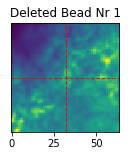

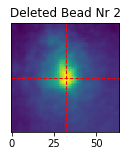

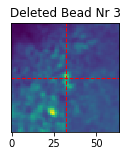

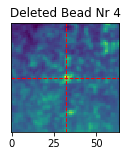

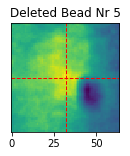

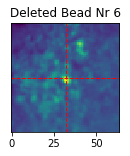

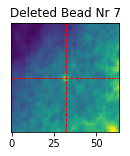

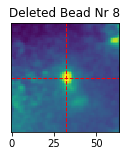

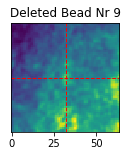

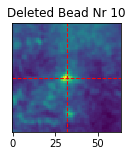

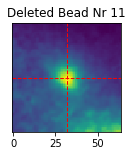

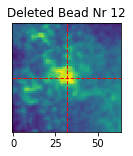

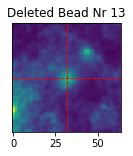

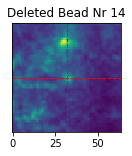

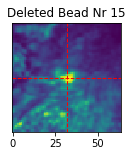

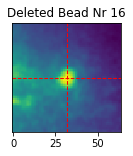

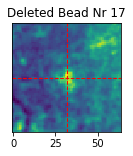

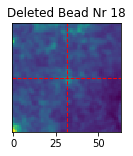

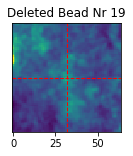

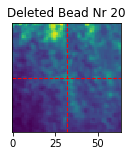

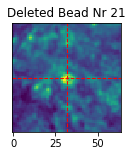

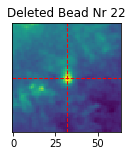

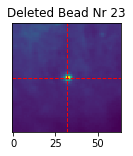

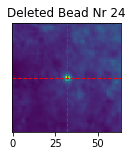

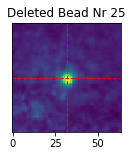

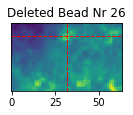

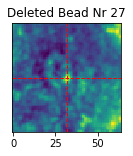

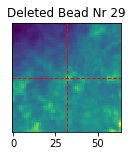

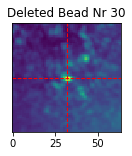

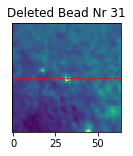

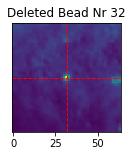

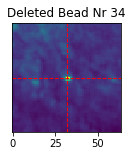

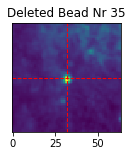

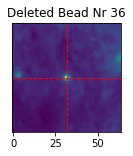

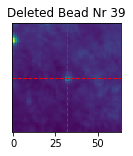

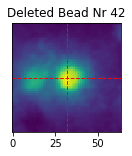

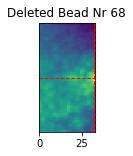

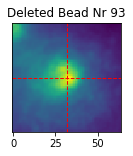

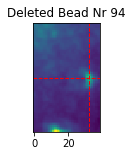

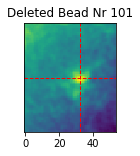

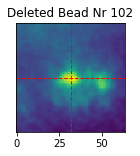

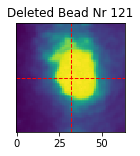

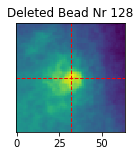

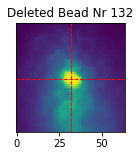

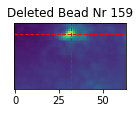

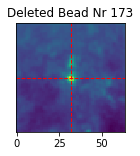

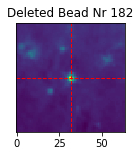

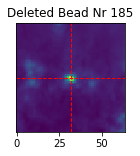

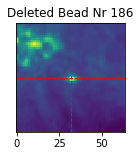

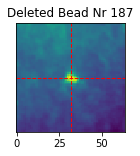

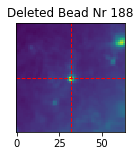

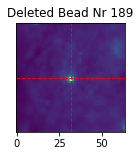

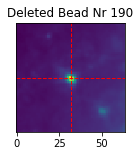

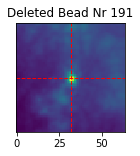

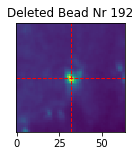

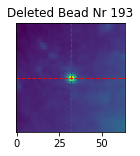

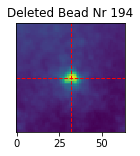

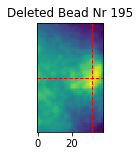

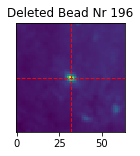

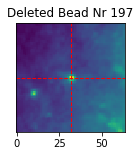

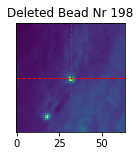

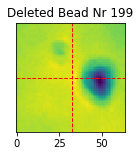

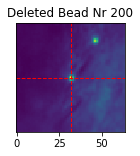

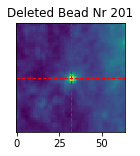

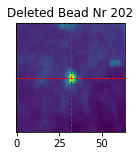

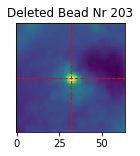

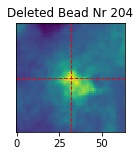

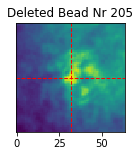

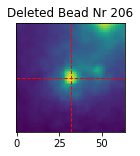

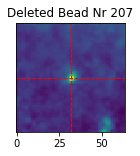

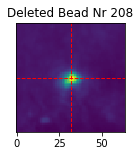

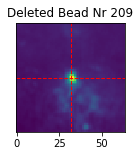

In [273]:
# Visulaize Deleted Beads
visualizeDeletedBeads(img,isBead,xLimit,yLimit,detectedBeadPos)

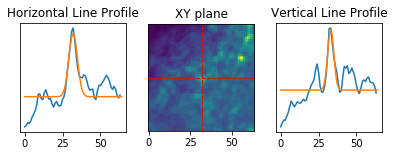

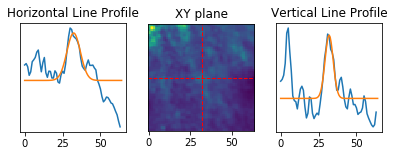

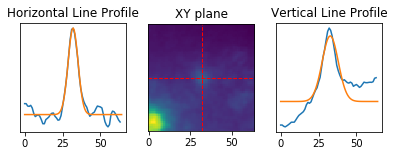

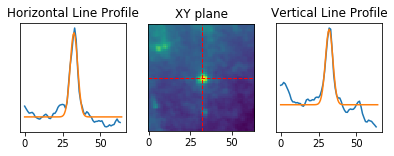

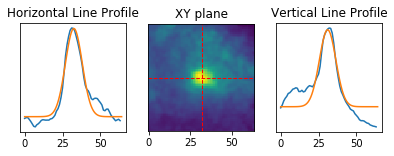

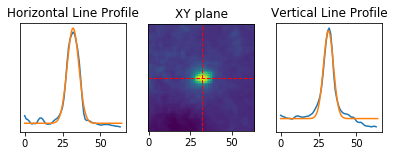

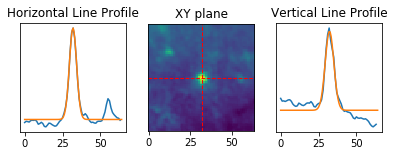

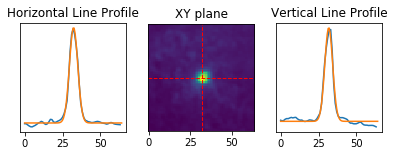

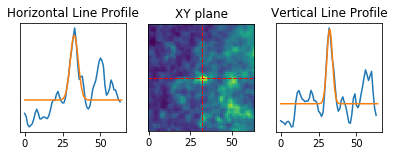

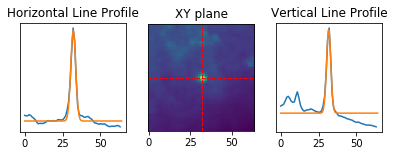

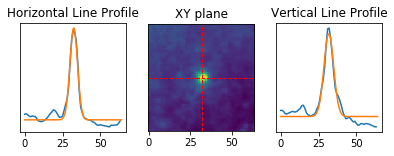

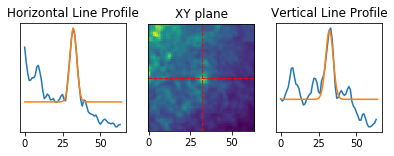

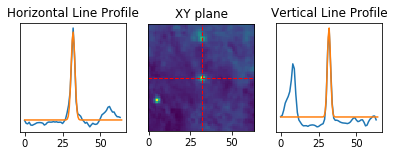

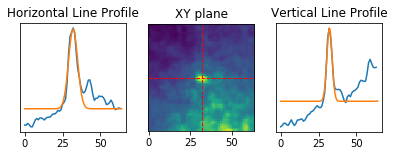

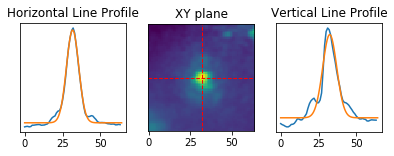

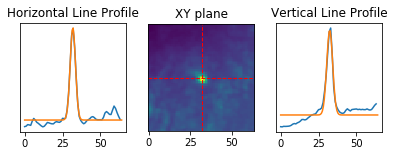

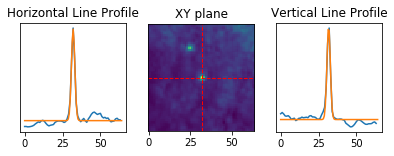

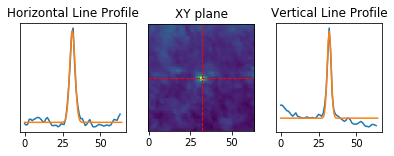

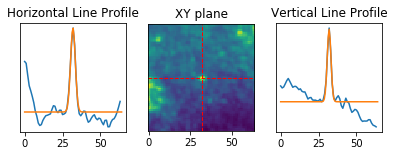

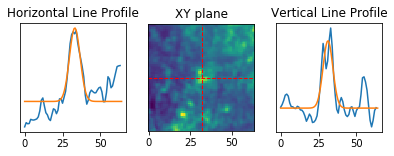

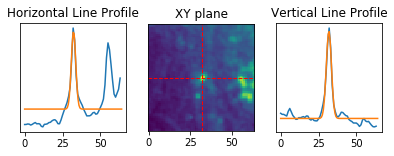

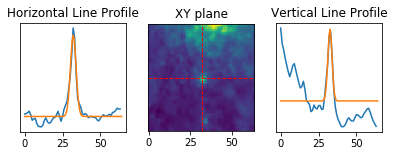

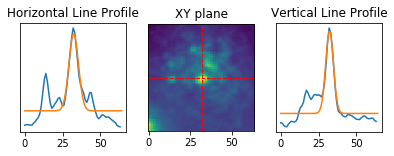

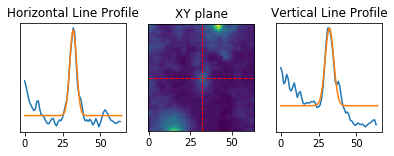

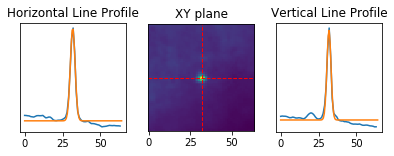

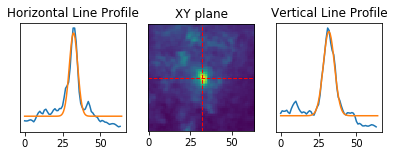

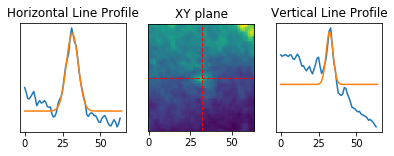

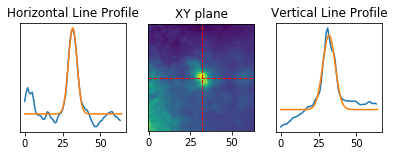

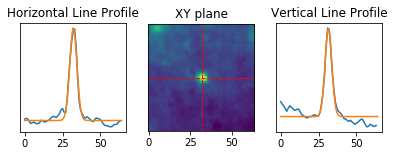

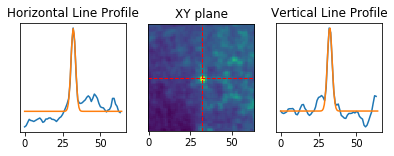

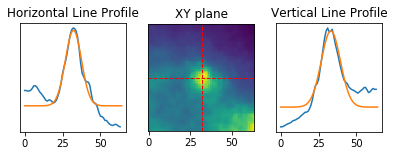

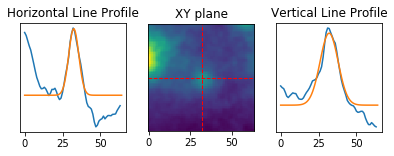

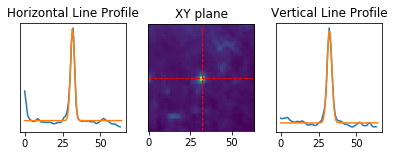

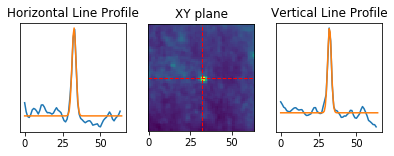

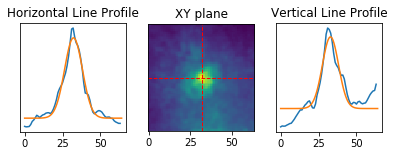

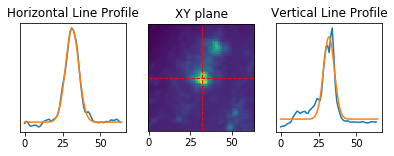

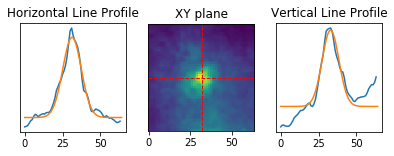

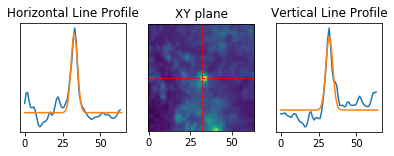

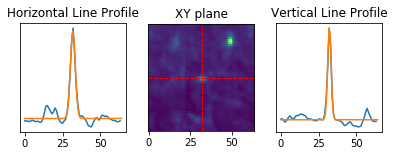

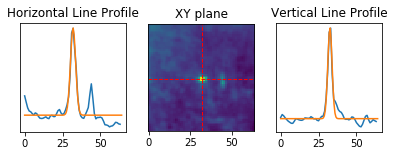

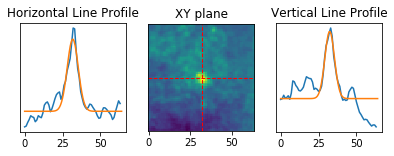

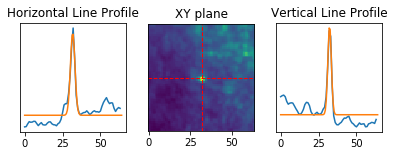

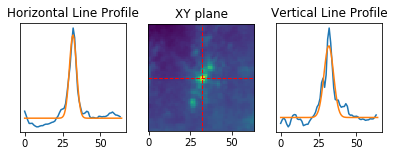

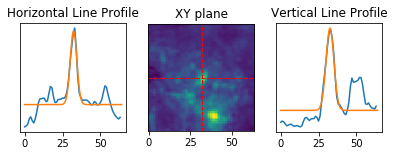

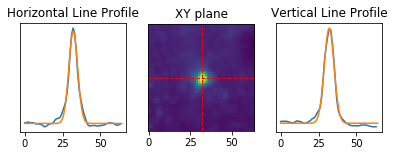

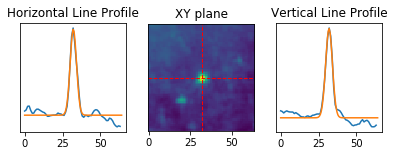

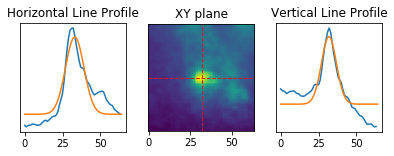

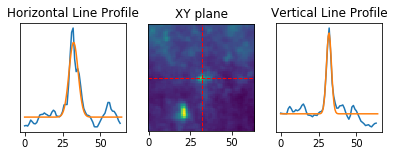

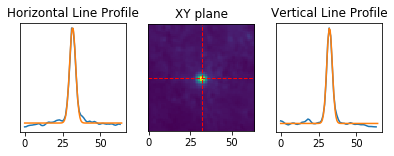

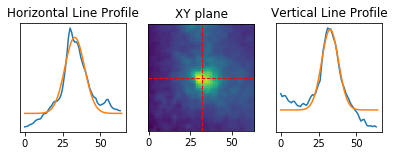

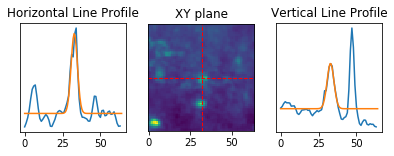

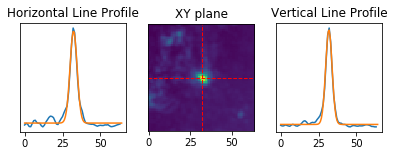

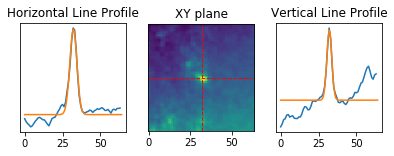

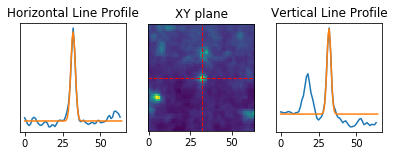

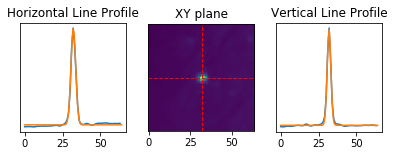

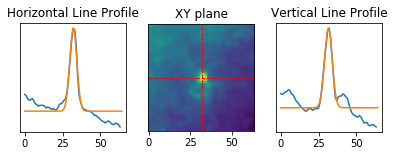

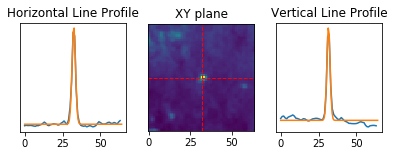

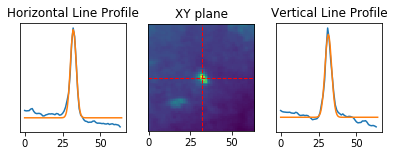

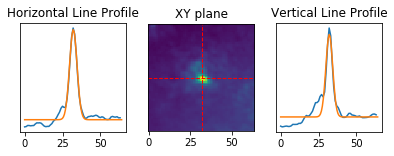

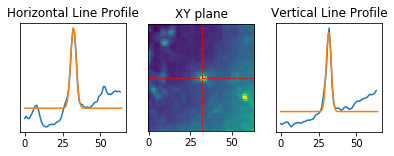

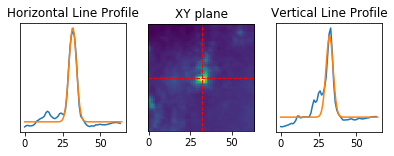

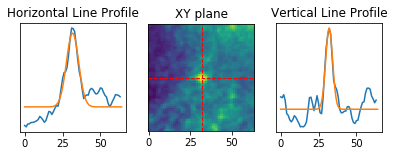

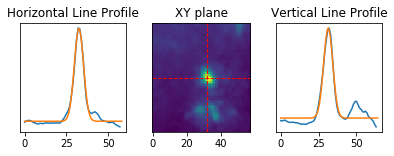

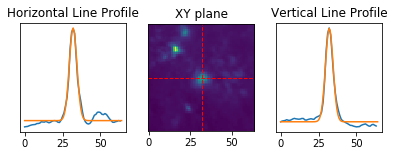

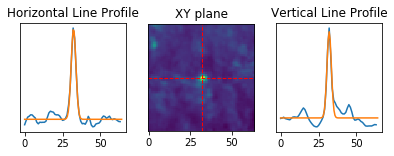

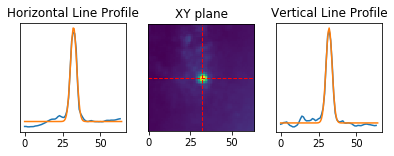

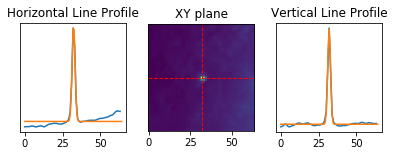

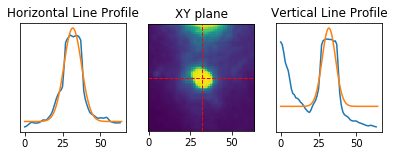

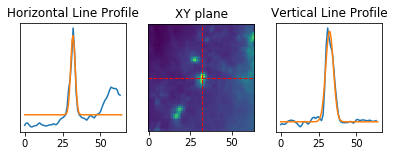

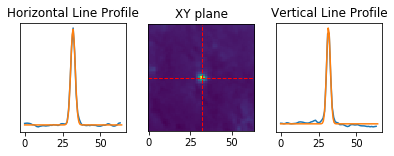

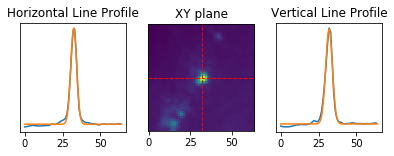

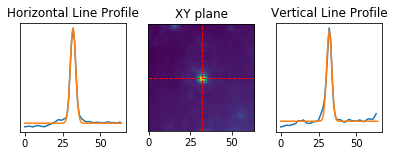

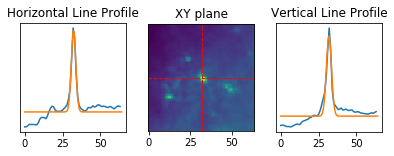

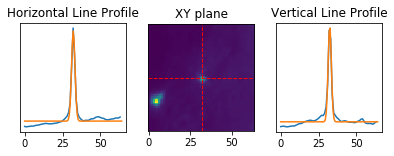

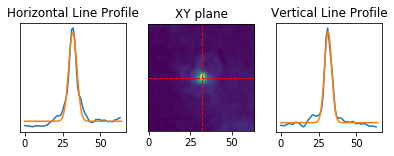

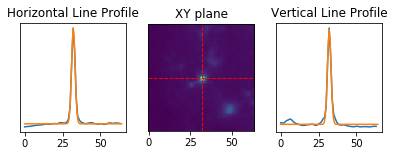

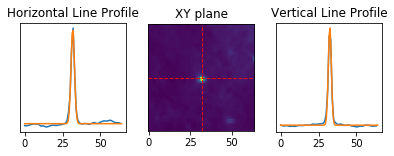

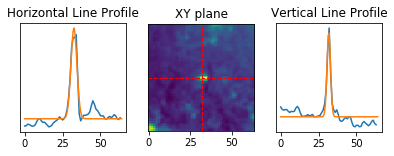

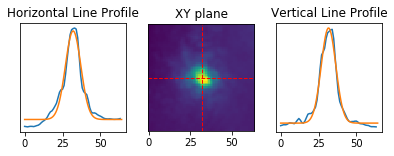

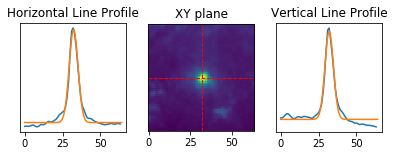

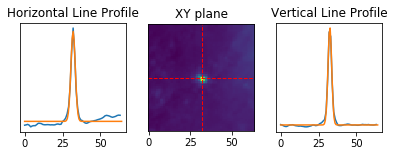

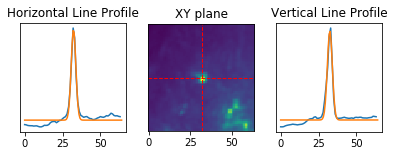

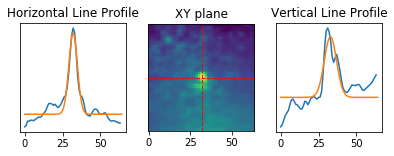

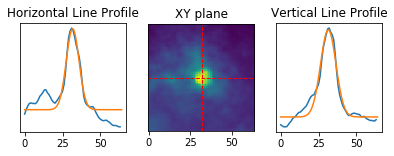

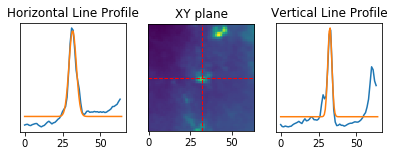

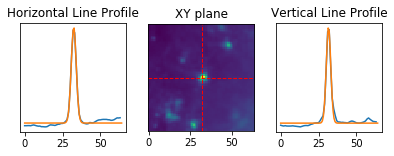

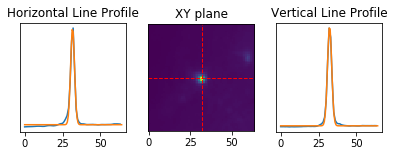

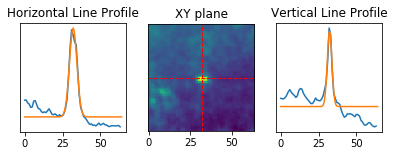

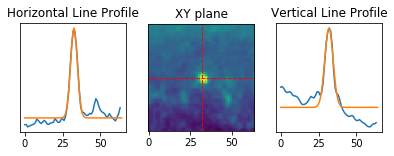

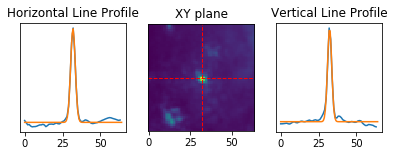

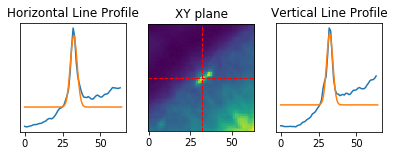

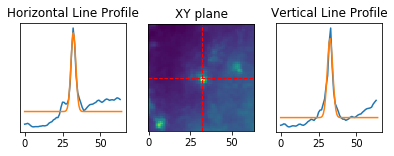

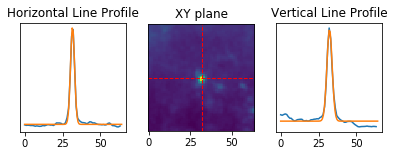

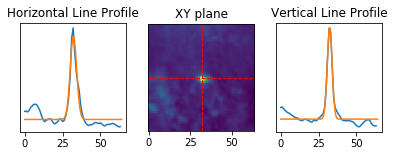

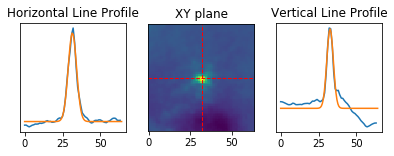

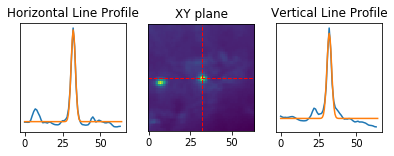

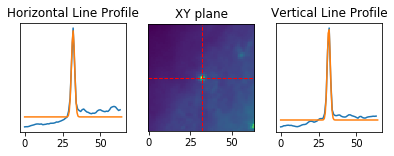

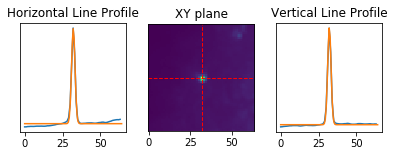

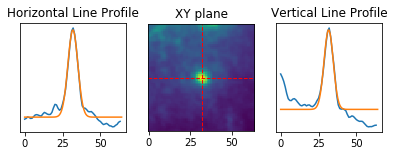

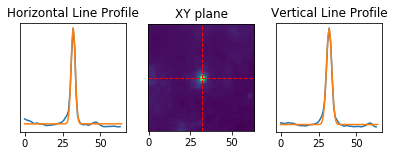

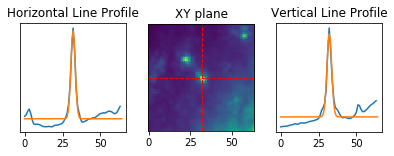

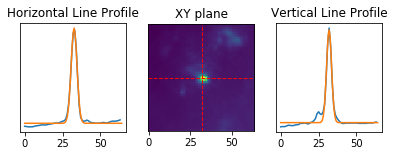

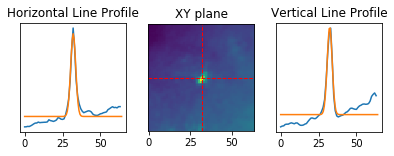

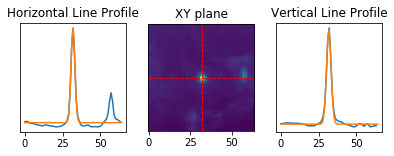

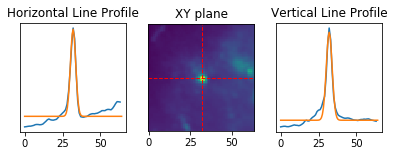

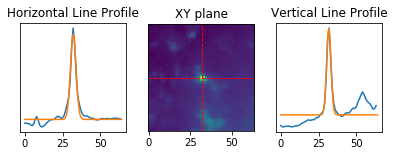

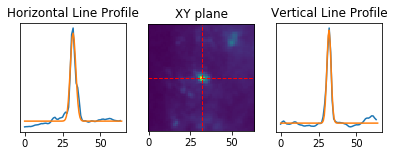

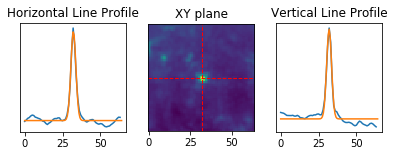

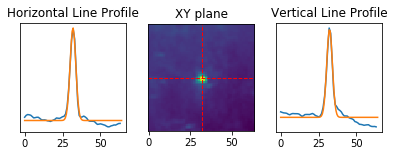

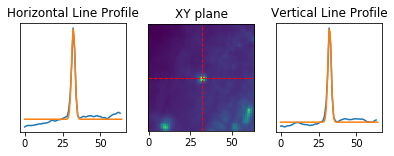

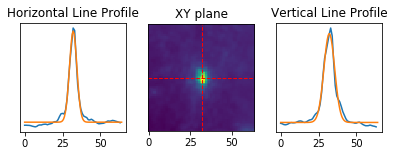

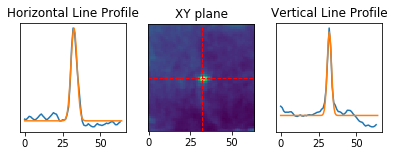

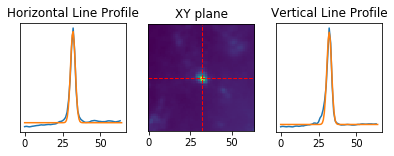

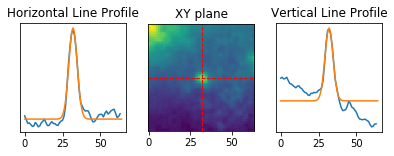

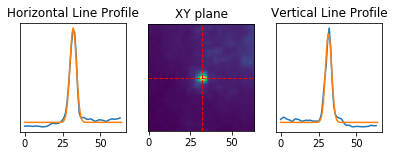

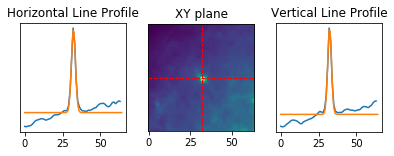

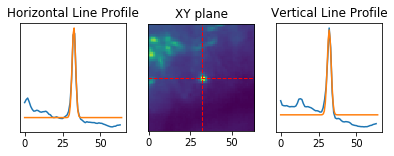

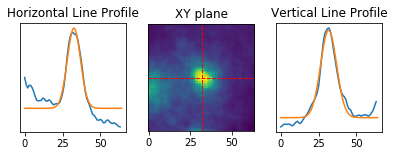

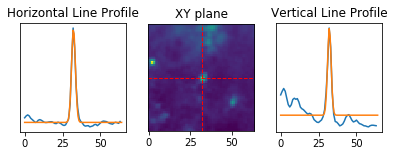

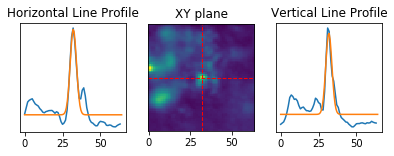

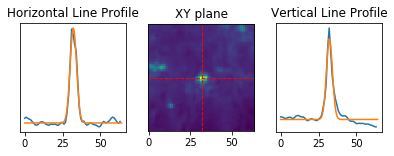

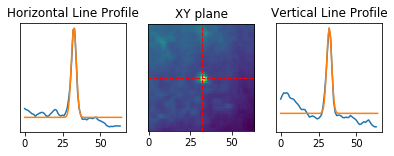

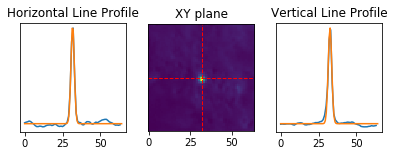

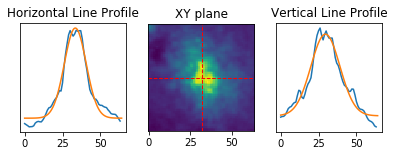

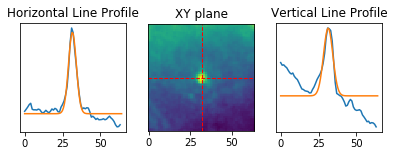

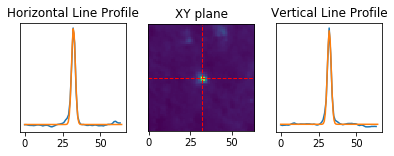

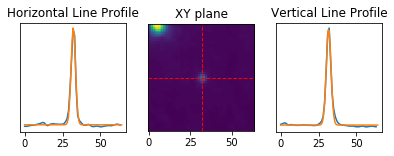

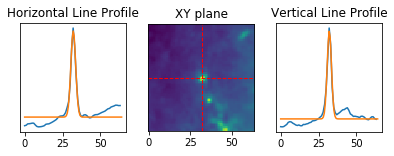

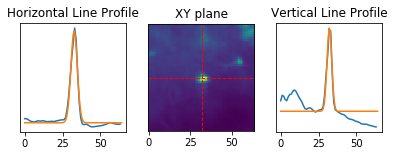

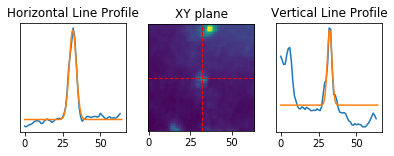

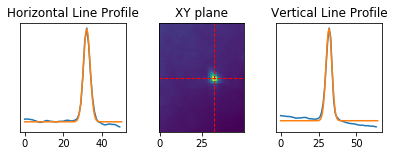

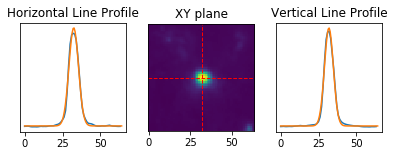

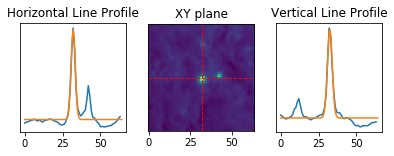

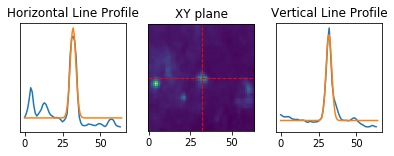

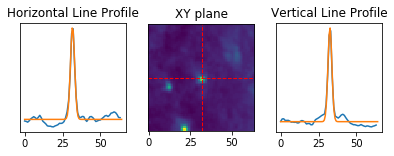

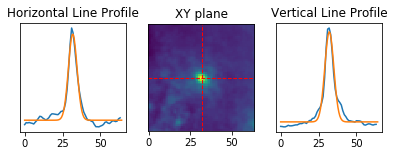

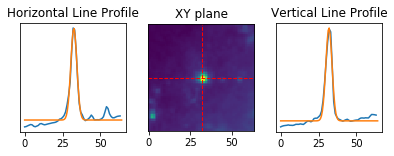

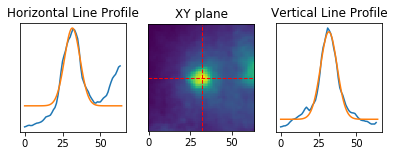

In [274]:
def visualizeWellFittedBeads(isBead, XParam, YParam, XSignal, YSignal, xLimit, yLimit, pos):
    z,y,x = pos[:,0],pos[:,1],pos[:,2]
    for beadNum in range(len(isBead)):
        if isBead[beadNum]:
            plt.figure(figsize = (6.5,2))
            plt.subplot(1,3,1)
            plt.plot(XSignal[beadNum])
            plt.plot()
            plt.yticks([])
            plotx = np.linspace(0, len(XSignal[beadNum]), 101)
            ploty = gaussian(plotx, XParam[beadNum,0], XParam[beadNum,1], XParam[beadNum,2], XParam[beadNum,3])
            plt.plot(plotx,ploty)
            plt.title("Horizontal Line Profile")
            plt.subplot(1,3,2)
            plt.imshow(img[int(z[beadNum]),
                   np.maximum(int(y[beadNum])-(yLimit//2),0):np.minimum(int(y[beadNum])+(yLimit//2),img.shape[1]),
                    np.maximum(int(x[beadNum])-(xLimit//2),0):np.minimum(int(x[beadNum])+(xLimit//2),img.shape[2])])
            plt.yticks([])
            plt.axhline(y[beadNum]-np.maximum(int(y[beadNum])-(yLimit//2),0), color='r', linestyle='--',linewidth = 1)
            plt.axvline(x[beadNum]-np.maximum(int(x[beadNum])-(xLimit//2),0), color='r', linestyle='--',linewidth = 1)
            plt.title("XY plane")
            plt.subplot(1,3,3)
            plt.plot(YSignal[beadNum])
            plt.plot()
            plt.yticks([])
            _plotx = np.linspace(0, len(YSignal[beadNum]), 101)
            _ploty = gaussian(_plotx, YParam[beadNum,0], YParam[beadNum,1], YParam[beadNum,2], YParam[beadNum,3])
            plt.plot(_plotx,_ploty)
            plt.title("Vertical Line Profile")

            #print(XErr[i])
            plt.show()
            
visualizeWellFittedBeads(isBead, XParam, YParam, XSignal, YSignal, xLimit, yLimit, detectedBeadPos)

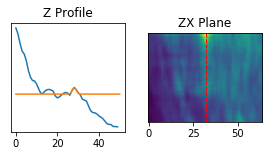

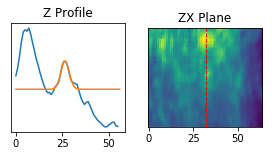

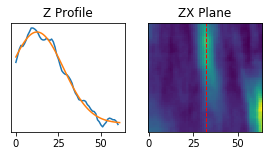

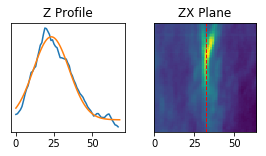

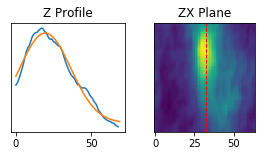

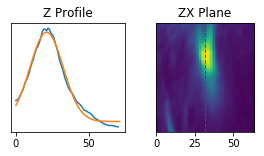

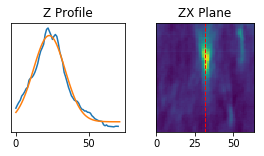

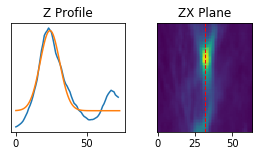

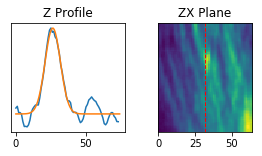

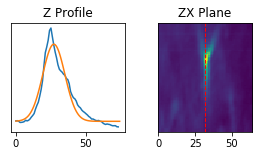

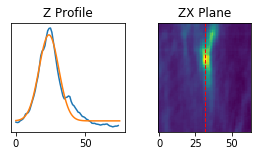

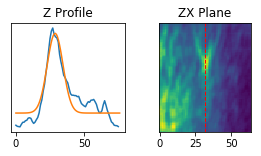

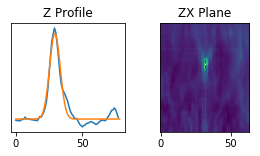

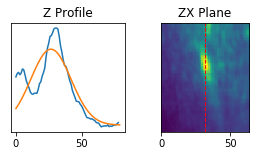

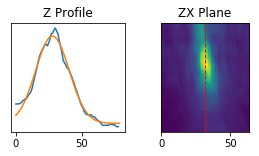

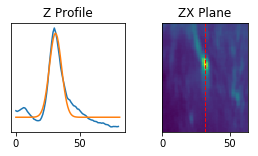

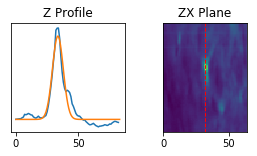

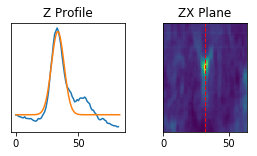

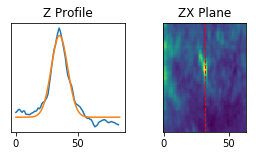

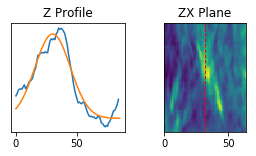

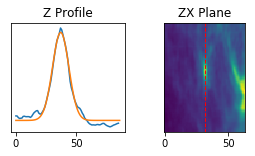

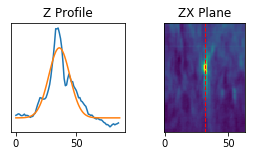

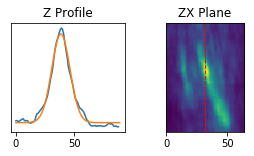

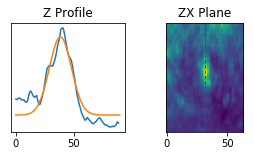

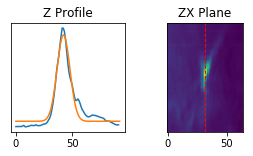

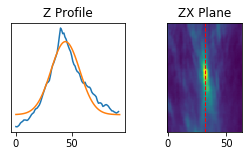

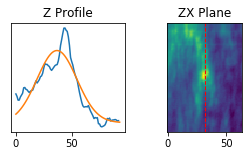

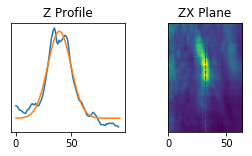

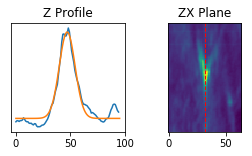

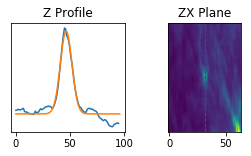

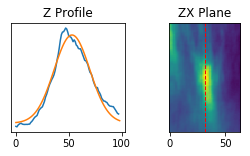

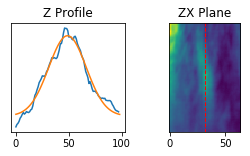

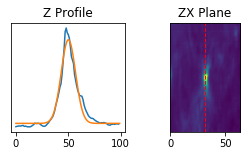

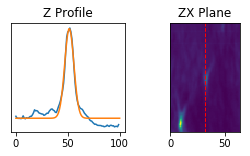

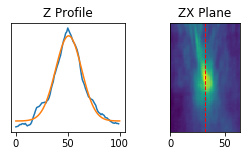

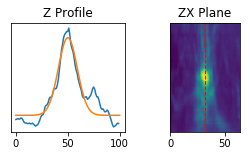

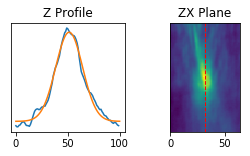

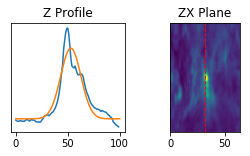

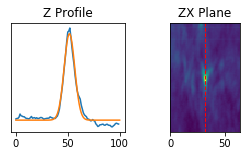

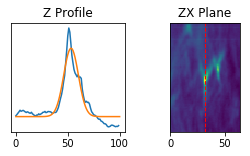

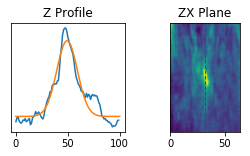

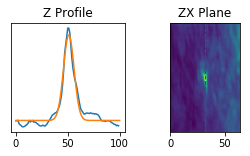

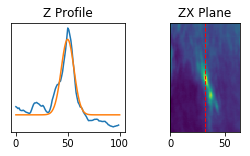

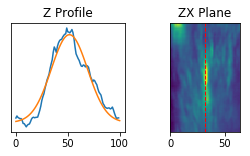

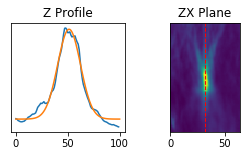

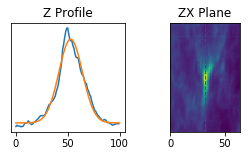

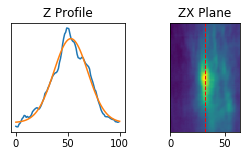

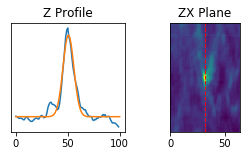

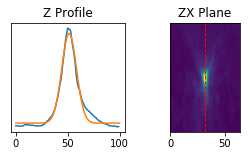

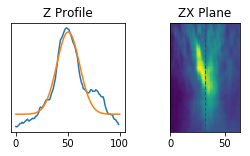

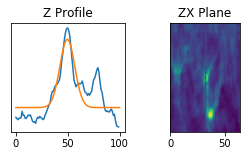

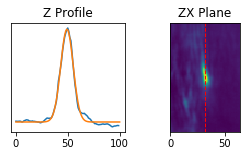

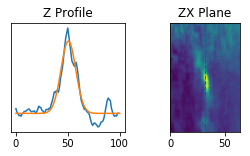

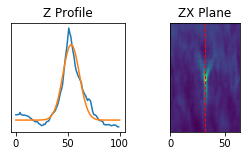

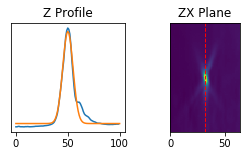

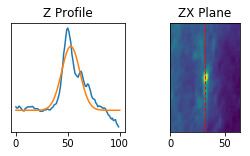

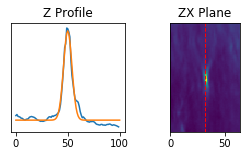

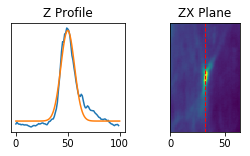

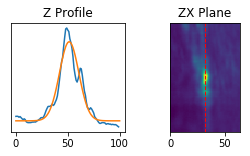

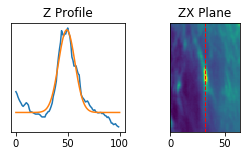

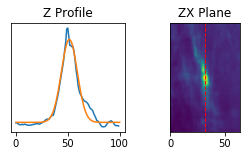

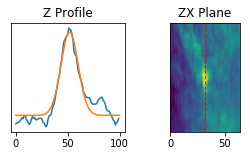

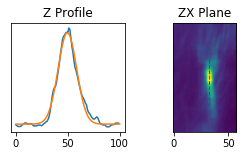

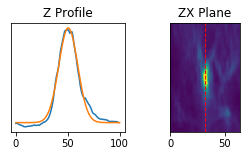

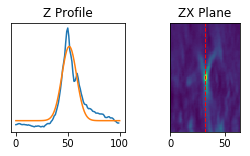

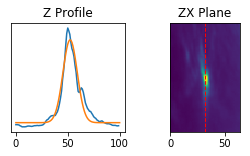

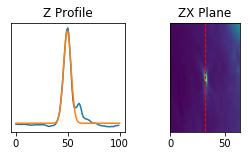

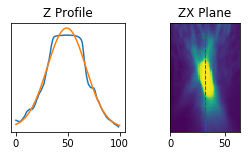

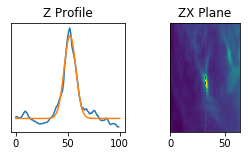

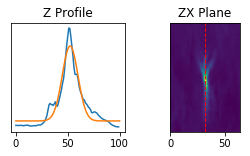

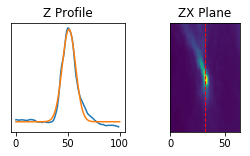

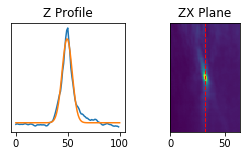

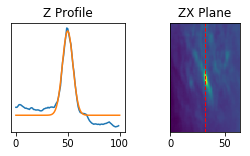

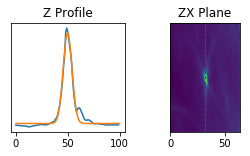

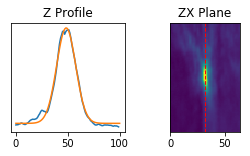

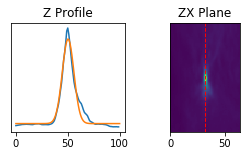

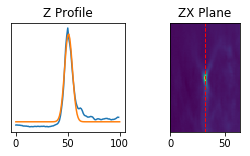

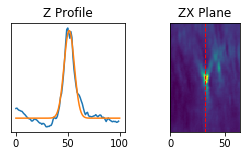

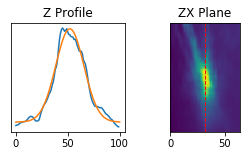

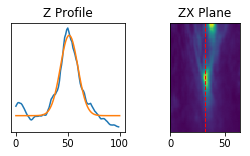

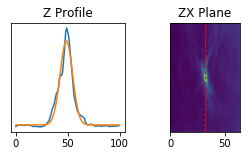

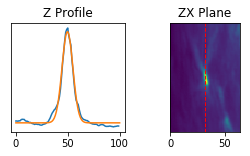

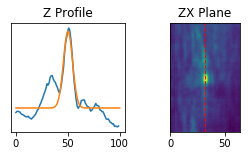

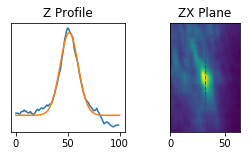

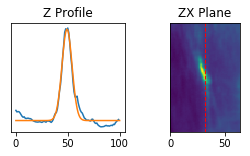

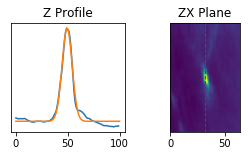

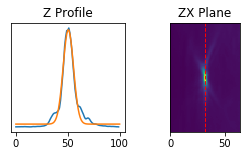

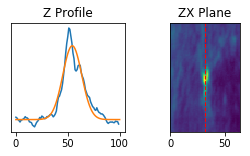

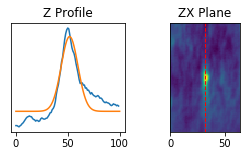

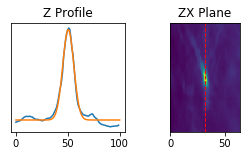

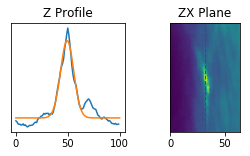

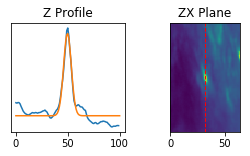

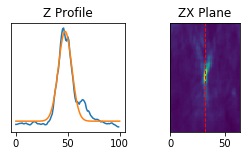

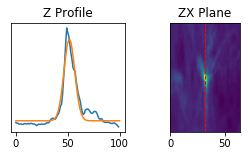

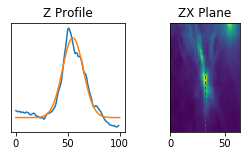

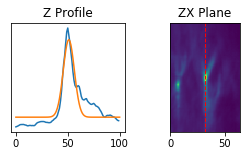

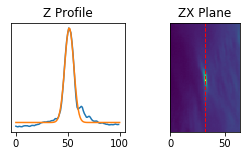

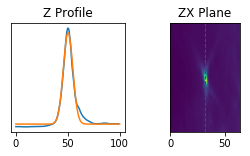

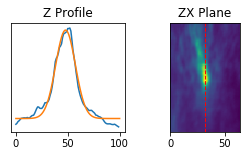

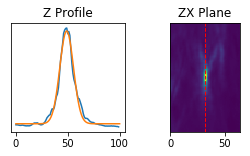

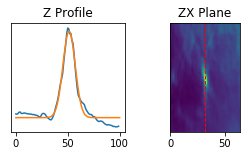

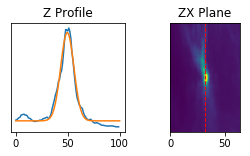

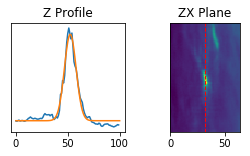

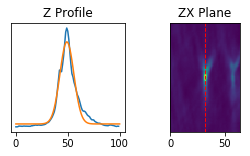

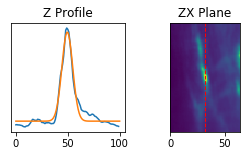

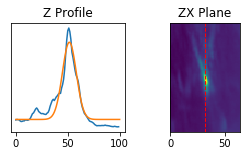

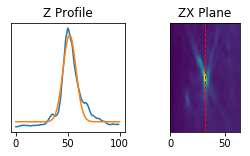

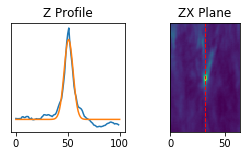

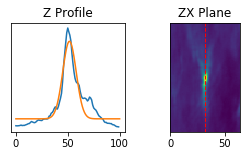

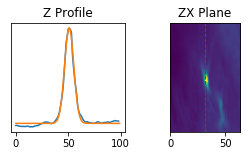

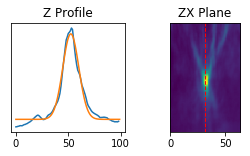

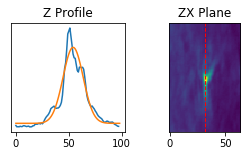

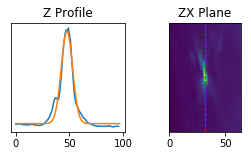

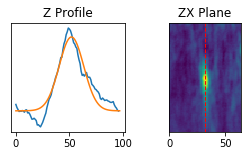

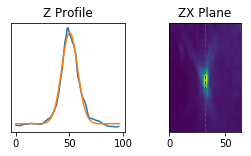

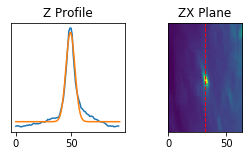

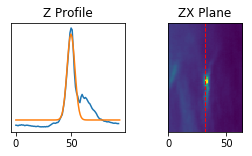

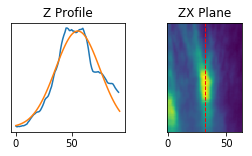

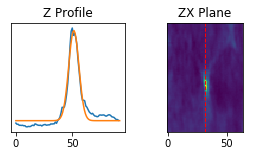

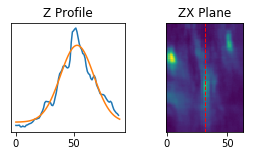

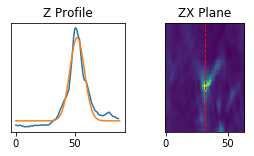

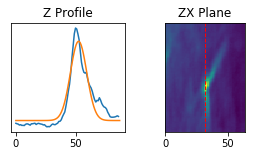

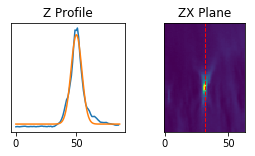

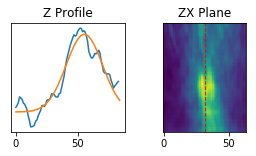

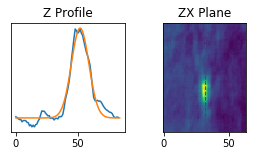

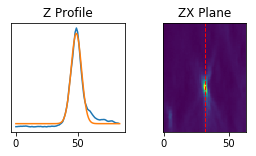

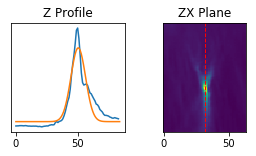

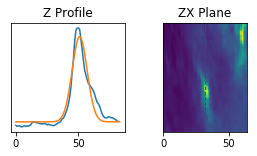

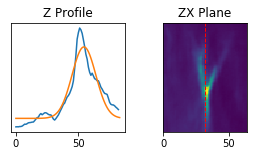

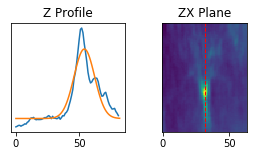

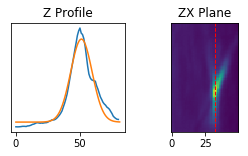

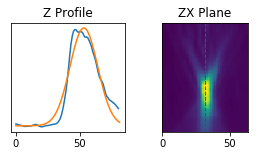

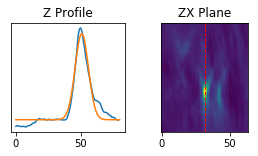

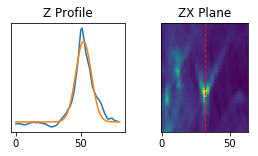

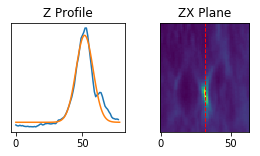

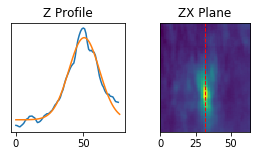

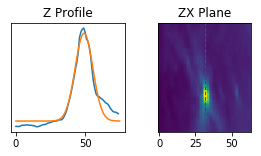

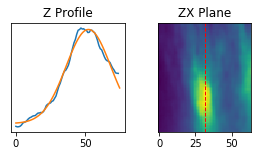

In [283]:
def VisualizeWellFittedBeadsZProfile(isBead, ZSignal, ZParam, zLimit):
    for beadNum in range(len(isBead)):
        if isBead[beadNum]:
            plt.figure(figsize = (4.5,2))
            plt.subplot(1,2,1)
            plt.plot(ZSignal[beadNum])
            plt.plot()
            plt.yticks([])
            plotx = np.linspace(0, len(ZSignal[beadNum]), 101)
            ploty = gaussian(plotx, ZParam[beadNum,0], ZParam[beadNum,1], ZParam[beadNum,2], ZParam[beadNum,3])
            plt.plot(plotx,ploty)
            plt.title("Z Profile")
            plt.subplot(1,2,2)
            plt.imshow(img[np.maximum(int(z[beadNum])-(zLimit//2),0):np.minimum(int(z[beadNum])+(zLimit//2),img.shape[1]),
                    int(y[beadNum]),   
                    np.maximum(int(x[beadNum])-(xLimit//2),0):np.minimum(int(x[beadNum])+(xLimit//2),img.shape[2])])
            plt.yticks([])
            plt.axvline(x[beadNum]-np.maximum(int(x[beadNum])-(xLimit//2),0), color='r', linestyle='--',linewidth = 1)
            plt.title("ZX Plane")
            plt.show()

            
VisualizeWellFittedBeadsZProfile(isBead, ZSignal, ZParam, zLimit)

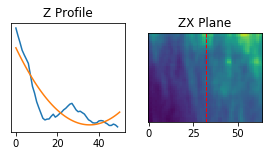

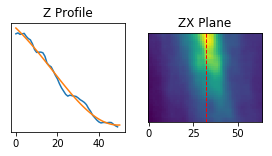

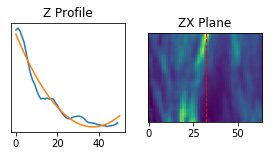

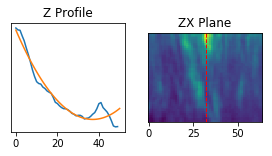

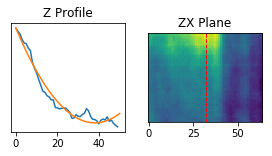

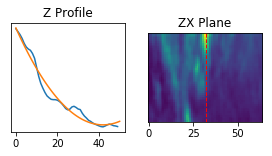

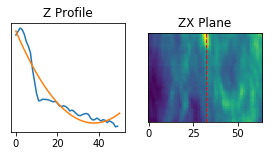

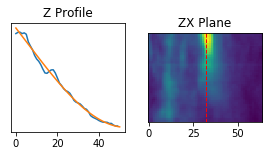

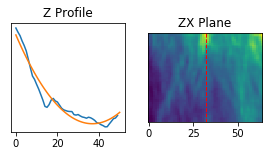

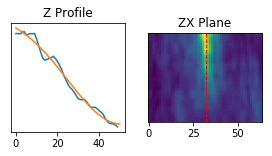

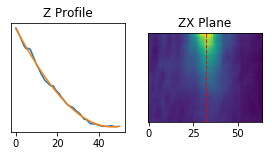

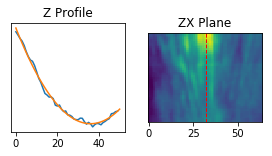

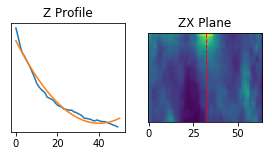

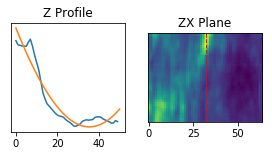

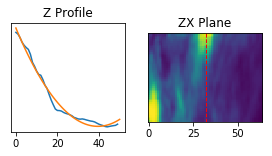

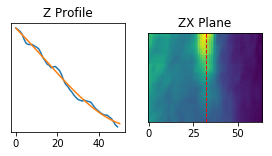

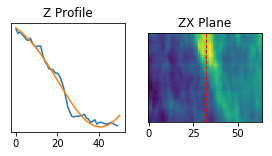

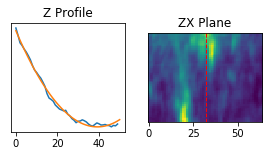

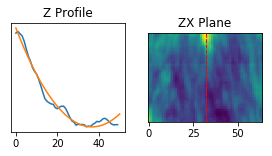

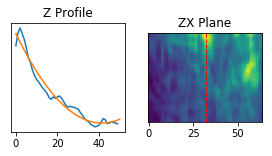

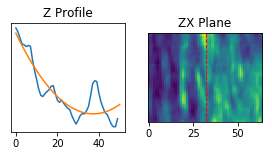

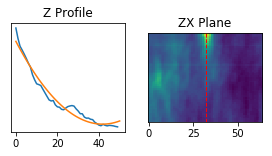

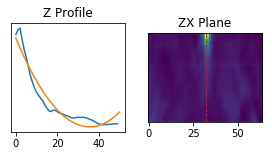

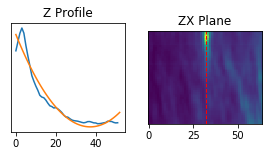

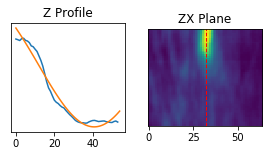

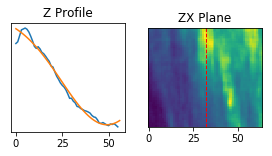

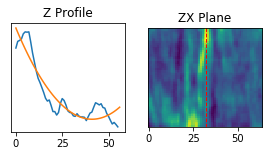

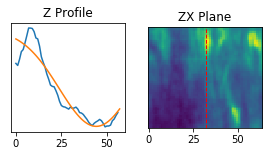

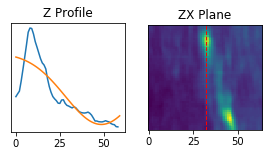

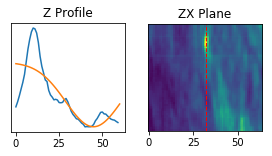

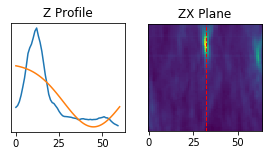

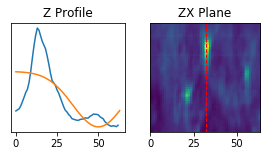

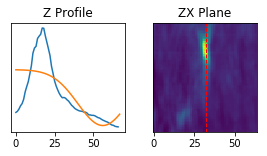

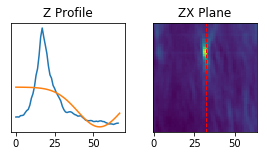

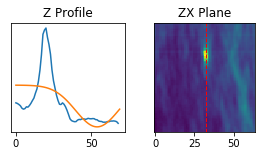

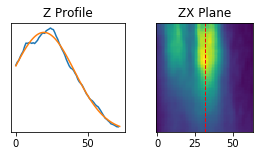

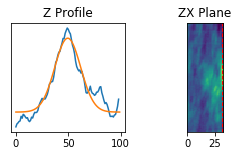

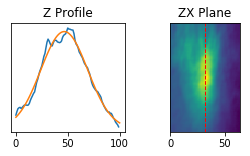

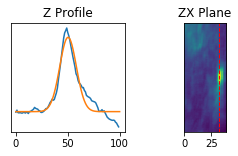

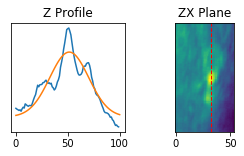

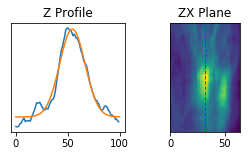

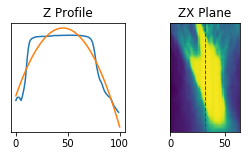

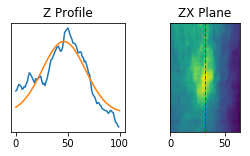

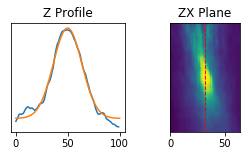

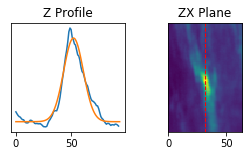

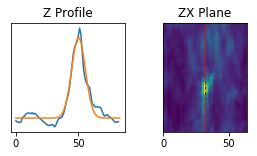

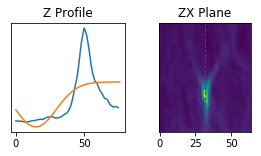

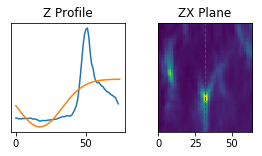

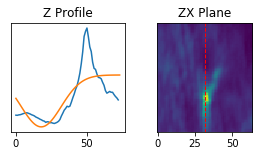

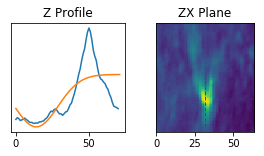

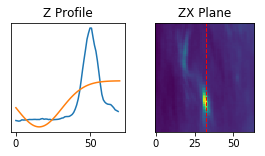

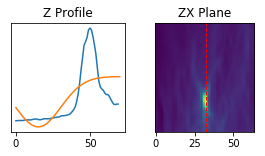

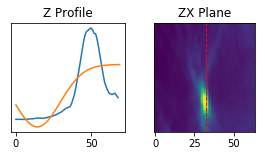

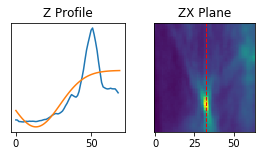

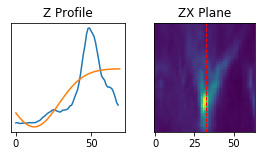

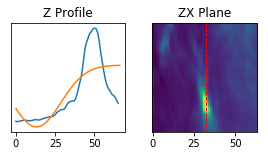

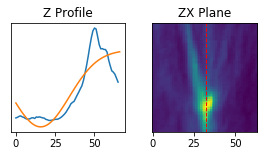

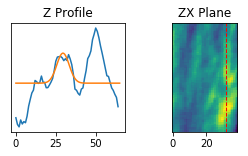

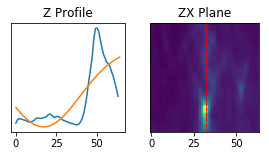

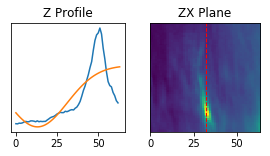

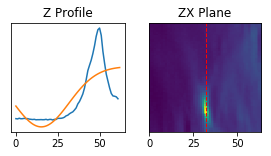

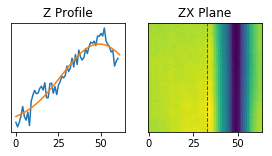

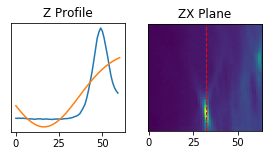

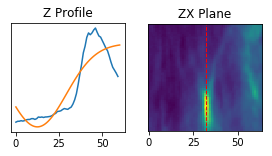

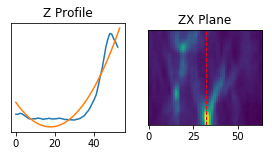

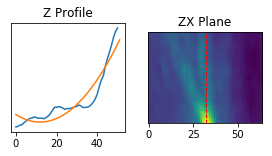

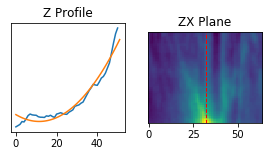

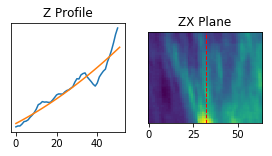

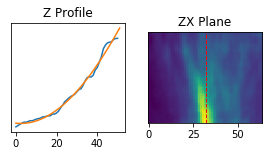

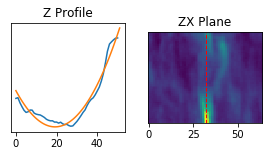

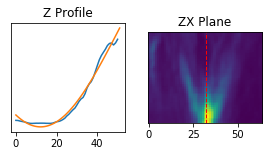

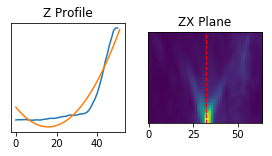

In [290]:
def VisualizeDeletedBeadsZProfile(isBead, ZSignal, ZParam, zLimit):
    for beadNum in range(len(isBead)):
        if isBead[beadNum]==0:
            plt.figure(figsize = (4.5,2))
            plt.subplot(1,2,1)
            plt.plot(ZSignal[beadNum])
            plt.plot()
            plt.yticks([])
            plotx = np.linspace(0, len(ZSignal[beadNum]), 101)
            ploty = gaussian(plotx, ZParam[beadNum,0], ZParam[beadNum,1], ZParam[beadNum,2], ZParam[beadNum,3])
            plt.plot(plotx,ploty)
            plt.title("Z Profile")
            plt.subplot(1,2,2)
            plt.imshow(img[np.maximum(int(z[beadNum])-(zLimit//2),0):np.minimum(int(z[beadNum])+(zLimit//2),img.shape[1]),
                    int(y[beadNum]),   
                    np.maximum(int(x[beadNum])-(xLimit//2),0):np.minimum(int(x[beadNum])+(xLimit//2),img.shape[2])])
            plt.yticks([])
            plt.axvline(x[beadNum]-np.maximum(int(x[beadNum])-(xLimit//2),0), color='r', linestyle='--',linewidth = 1)
            plt.title("ZX Plane")
            plt.show()

            
VisualizeDeletedBeadsZProfile(isBead, ZSignal, ZParam, zLimit)

In [286]:
isBead

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
        0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1